### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>

Основано на https://github.com/Practical_DL

In [ ]:
%env CUDA_VISIBLE_DEVICES=1

In [3]:
# 1. Не забудь сменить Runtime: to Runtime -> Change Runtime Type -> GPU
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

--2020-04-16 15:41:07--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2734 (2.7K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.67K  --.-KB/s    in 0s      

2020-04-16 15:41:07 (31.9 MB/s) - ‘lfw_dataset.py’ saved [2734/2734]



In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data).transpose([0,3,1,2]) / 255.

IMG_SHAPE = data.shape[1:]

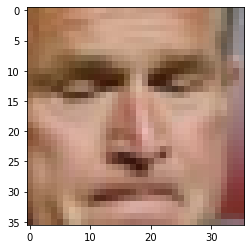

In [3]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])].transpose([1,2,0]),
           cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Глубокое обучение просто, не так ли?
* построить сеть, которая генерирует лицо (маленькое изображение)
* составьте __measure__ из __ насколько хорошо это лицо __
* оптимизировать с градиентным спуском :)


Единственная проблема: как мы, инженеры, можем отличить хорошо сформированные лица от плохих? Бьюсь об заклад, мы не будем просить дизайнера о помощи.

__Если мы не можем отличить хорошие лица от плохих, мы делегируем их еще одной нейронной сети! __

Это делает их двоих:
* __G__enerator - принимает случайный шум для вдохновения и пытается сгенерировать образец лица.
   * Давайте назовем его __G __ (z), где z - это гауссовский шум.
* __D__iscriminator - берет образец лица и пытается определить, хороший он или фальшивый.
   * Предсказывает вероятность того, что входное изображение будет "реальным лицом".
   * Давайте назовем его __D __ (x), где x - изображение.
   * __D (x) __ является предварительным условием для реального изображения, а __D (G (z)) __ является предсказанием для лица, созданного генератором.

Прежде чем мы углубимся в их обучение, давайте построим две сети.

In [4]:
import torch, torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 1.3.1
Using GPU


In [5]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)

In [6]:
CODE_SIZE = 256

generator = nn.Sequential(
    nn.Linear(CODE_SIZE, 10*8*8),
    nn.ELU(),
    Reshape([-1, 10, 8, 8]),
    nn.ConvTranspose2d(10, 64, kernel_size=(5,5)),
    nn.ELU(),
    nn.ConvTranspose2d(64, 64, kernel_size=(5,5)),
    nn.ELU(),
    nn.Upsample(scale_factor=2),
    nn.ConvTranspose2d(64, 32, kernel_size=(5,5)),
    nn.ELU(),
    nn.ConvTranspose2d(32, 32, kernel_size=(5,5)),
    nn.Conv2d(32, 3, kernel_size=(5,5))
)

if use_cuda: generator.cuda()

In [7]:
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generated_data.shape)

### Discriminator

* Дискриминатор - это ваша обычная сверточная сеть с пулингами
* Сеть не включает dropout/batchnorm, чтобы избежать осложнений при обучении.
* Мы также нормализуем предпоследний слой, чтобы дискриминатор не был слишком точным.

In [8]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    batch = torch.tensor(data[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
discriminator = nn.Sequential()

### YOUR CODE - create convolutional architecture for discriminator
### Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

# and a final layer...
discriminator.add_module("disc_logit", nn.Linear(<???>, 1))

if use_cuda: discriminator.cuda()

In [ ]:
discriminator(sample_data_batch(5))

# Training

Мы обучаем две сети одновременно:
* Тренируйте __discriminator__, чтобы лучше отличать реальные данные от генератора __current__
* Тренируйте __generator__, чтобы заставить дискриминатора думать, что генератор настоящий
* Поскольку дискриминатор является дифференцируемой нейронной сетью, мы тренируемся с градиентным спуском.


Обучение проводится итеративно до тех пор, пока дискриминатор больше не сможет найти разницу (или пока у вас не закончится терпение).


### Tricks:
* Регуляризация выходного веса дискриминатора для предотвращения gradient explosion
* Тренируйте генератор с __adam__, чтобы ускорить обучение. Дискриминатор тренируется с SGD, чтобы избежать проблем с моментами.
* Подробнее: https://github.com/soumith/ganhacks

In [ ]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = <generate data given noise>
    
    disc_on_generated_data = <discriminator's opinion on generated data>
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    
    loss = - <generator loss>
    
    return loss

In [ ]:
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 0, "loss must be scalar"

In [ ]:
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = <discriminator's opinion on real data>
    disc_on_fake_data = <discriminator's opinion on generated data>
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(- logp_gen_is_fake)
    
    loss = <discriminator loss>
    return loss

In [ ]:
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

### Auxilary functions
Здесь мы определяем несколько вспомогательных функций, которые рисуют текущие распределения данных и образцы данных обучения.

In [ ]:
def sample_images(nrow,ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0,2,3,1])
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i],cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i],cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = F.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = F.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training



In [ ]:
#optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [ ]:
from IPython import display
from tqdm import tnrange
batch_size = 100

for epoch in tnrange(50000):
    
    # Train discriminator
    for i in range(5):
        real_data = sample_data_batch(batch_size)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()
        
    # Train generator
    noise = sample_noise_batch(batch_size)
    loss = generator_loss(noise)
    gen_opt.zero_grad()
    loss.backward()
    gen_opt.step()
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        

In [ ]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)